In [1]:
# Implementing Echo State Network for Artificial Grammar Learning(Reber)

In [2]:
# Importing required modules

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

In [5]:
# Generating Reber Strings

In [6]:
import random as rnd

class ReberGrammarLexicon(object):

    lexicon = set() #contain Reber words
    graph = [ [(1,'T'), (2,'P')], \
            [(1, 'S'), (3, 'X')], \
            [(2,'T') ,(4, 'V')],  \
            [(2, 'X'), (5,'S')],           \
            [(3, 'P'),(5, 'V')],  \
            [(6,'E')] ]  #store the graph

    def __init__(self, num, maxSize = 1000): #fill Lexicon with num words

        self.maxSize = maxSize

        if maxSize < 5:
            raise NameError('maxSize too small, require maxSize > 4') 

        while len(self.lexicon) < num:

            word = self.generateWord()
            if word != None:
                self.lexicon.add(word)

    def generateWord(self): #generate one word

    #    c = 2
        currentEdge = 0
        word = 'B'

        while True:

            inc = rnd.randint(0,len(self.graph[currentEdge])-1)
            nextEdge = self.graph[currentEdge][inc][0]
            word += self.graph[currentEdge][inc][1]
            currentEdge = nextEdge
            if currentEdge == 6 :
                break
    #        c+=1

    #    if c > self.maxSize :
    #        return None

        return word

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [8]:
data = ['B', 'E', 'P', 'S', 'T', 'V', 'X']
values = np.array(data)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)

In [9]:
def func(word,start=0):
    word = np.array(list(word[start:]))
    encoded = label_encoder.transform(word)
    return onehot_encoded.transform(encoded.reshape(-1,1))    

In [10]:
def preprocessing(dictionary,start=0):
    length = len(dictionary)
    result = func(list(dictionary)[0])
    
    for word in list(dictionary)[1:]:
        b = func(word)
        result = np.vstack((result,b))
        
        
    return result     

In [11]:
generator = ReberGrammarLexicon(2000,maxSize=20)

In [12]:
generator.lexicon

{'BTXXTTTVPSE',
 'BTSXXTTTVPXVPXTTVPSE',
 'BPTTVPXTTVPXTTTVVE',
 'BTSSSSXXVPSE',
 'BTSSSSSSXXTTVPXVPXTVVE',
 'BTSSSSXXVPXTTTVVE',
 'BPTTTTVPXVPXTTVVE',
 'BTSSXXTVPXTVPXVPXTVVE',
 'BPTVPXTVVE',
 'BTSSSSSSSSSSSXXTTTVVE',
 'BTSSSXXTVPXVPXVVE',
 'BPVPXTTTVPXTTTTTVVE',
 'BTXXTTTTVPXVPXVVE',
 'BTSSXXTTTVPXTTVVE',
 'BTXXTTVPXTTVPXTVPSE',
 'BPTTVPXTTTTVPXVPXTVPSE',
 'BTSSSSSSSSXXTTTTTTTTVPXTTVPXVVE',
 'BTSXXTTTTVPXTVPXTVPXTTTVPXTVVE',
 'BTSSSSXXVPXVVE',
 'BPTTVPXTVPXVPXTTVVE',
 'BTSSXXTTTTTVPXTVPXTVPXVVE',
 'BTSSSSSSSXXTTVPXTVVE',
 'BPVPXVPXVPXTTVVE',
 'BTSXXVPXTTVPSE',
 'BPTVPXTTVPXTVPXVVE',
 'BPTTVPXTTTTVPXTTTTTVPSE',
 'BPTTVPXTVPXVPXTTTVVE',
 'BTSXXTVPXTTTTVPSE',
 'BPTTTVPXTVPXVPXVPSE',
 'BPTTVPXVPXVPXTVPXVPXTTVVE',
 'BTSSSSXXTTTTTTVPXVVE',
 'BPVPXVPXTTTTTTTVPSE',
 'BTSXXTVPXTTTTTTTTTTVPXVVE',
 'BTSXXVPXTTVPXTTTTTTTTVPXVPXTVVE',
 'BPTTTTVPXTTTTVVE',
 'BPTTVPXTTVPXTTVVE',
 'BTSXSE',
 'BTSSSSSSSSXXVPXTTTTVPSE',
 'BTSSSSSXXTVVE',
 'BTSXXVPXTTTTVPXTTTTVPXVVE',
 'BTSXXTTVPXTTTVVE',
 'BPVPXTVPXTT

In [13]:
training_set = preprocessing(list(generator.lexicon)[:2000])

In [14]:
training_set.shape

(37929, 7)

In [15]:
# Setting random seed

In [16]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

In [17]:
# Creating Network Class

In [18]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.data = training_set
        self.inSize = self.outSize = 7 #Input/Output dimensions
        self.resSize = 400 #Reservoir size (prediction)
        #self.resSize = 1000 #Reservoir size (generation)
        self.a = 0.3 #Leak rate alpha
        self.spectral_radius = 1.25 #Spectral raidus
        self.input_scaling = 1. #Input scaling
        self.reg =  1e-8 #None #Regularization factor - if None,
        #self.reg = None
        #we'd use pseudo-inverse rather than ridge regression

        self.mode = 'prediction'
        #self.mode = 'generative'

        #Change the seed, reservoir performances should be averaged accross
        #at least 20 random instances (with the same set of parameters)
        seed = None #42

        set_seed(seed)
        
nw = Network()

1146683671
Seed used for random values: 1146683671


In [19]:
# Generating Win,W randomly and then generating X,Ytarget 

In [20]:
from scipy.sparse import random

In [21]:
def initialization(nw) :

    #Weights
    #nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    Win0 = random(nw.resSize,1+nw.inSize, density=0.25)
    nw.Win = Win0.toarray()
    #nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    W0 = random(nw.resSize,nw.resSize, density=0.25)
    nw.W = W0.toarray()
    
    #Matrices
    #Allocated memory for the design (collected states) matrix
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    #Set the corresponding target matrix directly
    nw.Ytarget = nw.data[None,nw.initLen+1:nw.trainLen+1]

    #Run the reservoir with the data and collect X
    nw.x = np.zeros((nw.resSize,1))  
    
    return(nw)

In [22]:
# Computing spectral radius(biggest of the absolute eigen values of W matrix) and then scaling W matrix using that

In [23]:
def compute_spectral_radius(nw):
    print('Computing spectral radius...',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('Done.')
    nw.W *= nw.spectral_radius / rhoW
    
    return(nw)

In [24]:
# Learning phase

In [25]:
# 𝑥𝑛 = (1−𝛼)𝑥𝑛 − 1 × 𝛼tanh(𝑊𝑖𝑛.𝑢𝑛 − 1) + 𝑊.𝑥𝑛−1

In [26]:
def learning_phase(nw) :
    for t in range(nw.trainLen):
        #Input data
        nw.u = nw.data[t]
        
        #if (nw.u == np.array((0, 1, 0, 0, 0, 0, 0))).all(): 
        #    nw.x = np.zeros((nw.resSize,1))
        #else:
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u.reshape(7,1))) ) + np.dot( nw.W, nw.x ) )
        #After the initialization, we start modifying X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u.reshape(7,1),nw.x.reshape(nw.resSize,1)))[:,0]
            
    return(nw)

In [27]:
# Training output weights using ridge regression
# 𝑊𝑜𝑢𝑡 = (𝑌𝑡.𝑋𝑇) . (𝑋.𝑋𝑇+𝑟𝑒𝑔.𝐼)^-1

In [28]:
def train_output(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # Ridge regression (linear regression with regularization)
    #    nw.Wout = np.dot(np.dot(nw.Ytarget[0].T,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T))) 
        nw.Wout = np.dot(np.dot(nw.Ytarget[0].T,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        # Pseudo-inverse
        nw.Wout = np.dot(nw.Ytarget[0].T, linalg.pinv(nw.X) )
        
    return(nw)

In [29]:
# Testing in a particular mode

In [30]:
def test(nw) :
    #Run the trained ESN in a generative mode. no need to initialize here, 
    #because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.testLen,nw.outSize))
    nw.u = nw.data[nw.trainLen]
    nw.x = nw.x_ini
    nw.reservoir = np.zeros((nw.testLen,nw.resSize+8))
    for t in range(nw.testLen):
        #if (nw.u == np.array((0, 1, 0, 0, 0, 0, 0))).all(): 
        #    nw.x = np.zeros((nw.resSize,1))
        #else:
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u.reshape(7,1))) ) + np.dot( nw.W, nw.x ) )
        
        nw.reservoir[t] = (np.vstack((1,nw.u.reshape(7,1),nw.x.reshape(nw.resSize,1)))).reshape(nw.resSize+8,)
        
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u.reshape(7,1),nw.x.reshape(nw.resSize,1))) )
        nw.Y[t][:] = nw.y.reshape(1,7)
        if nw.mode == 'generative':
            #Generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            #Predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    
    return(nw)

In [31]:
def compute_error(nw) :
    # Computing MSE for the first errorLen iterations
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [32]:
def compute_network(nw) :
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = learning_phase(nw)
    nw = train_output(nw)
    nw.x_ini = nw.x
    nw = test(nw)  
    nw = compute_error(nw)
    return(nw)

In [33]:
# Definition of the network parameters

In [34]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatSlider(value=300, min=0, max=1000, step=100, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=100, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=50000, step=500, description='trainLen')
var4 = FloatSlider(value=2000, min=0, max=5000, step=100, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.2, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.1, description='leak rate')
valid = Button(description='Validate')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    compute_network(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

InitLen: 200 TrainLen: 35000 TestLen: 2500
ResSize: 500 Spectral Radius: 1.25 Leak Rate: 1.0
Computing spectral radius... Done.
MSE = [0.05382813 0.9469755  0.13535751 0.09401983 0.32746922 0.17411786
 0.16246643]


In [36]:
y_pred = nw.Y

In [37]:
y_test = training_set[nw.trainLen+1:nw.trainLen+nw.testLen+1]

In [38]:
def top_2_accuracy(test_set,check):
    k = 0
    for i in range(nw.testLen):
        if (test_set[i].argmax() == check[i].argsort()[-1]) | (test_set[i].argmax() == check[i].argsort()[-2]):
            k += 1
    print(k/nw.testLen)        

In [39]:
top_2_accuracy(y_test,y_pred)

1.0


In [ ]:
chars='BEPSTVX'
print(list(chars))
print(np.round(y_pred,decimals=2)[:20])

In [40]:
u, s, vh = np.linalg.svd(nw.Wout, full_matrices=False)

In [ ]:
vh.size

In [ ]:
len(vh)

In [ ]:
vh.shape

In [45]:
np.round(u*1000)

array([[  -0.,    0.,    0.,   -0.,    0., -924., -383.],
       [   0.,    0.,   -0.,  850.,  334.,  156., -377.],
       [ 654.,  184., -454.,  -37., -406.,  156., -377.],
       [ 179., -684.,  -18., -370.,  443.,  157., -377.],
       [  57.,   -7.,  814.,  -36., -407.,  156., -377.],
       [-711., -176., -361.,  -36., -406.,  156., -377.],
       [-179.,  684.,   19., -370.,  443.,  157., -377.]])

-0.045389135314290174


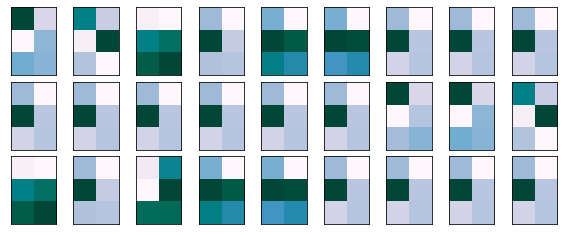

In [53]:
Data = np.zeros((27,6))
for i in range(27):
    for j in range(6):
    #    if j!=5:
        Data[i,j] = np.dot(nw.reservoir[i,8:],vh[j,8:])

print(np.min(Data))
Data = Data + np.min(Data)
        
def plot_digits(data):
    fig, axes = plt.subplots(3, 9, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(3, 2),cmap='PuBuGn')
plot_digits(Data)

In [ ]:
chars='BEPSTVX'

In [54]:
y_test[9:27]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [48]:
a = [1,2,3,4]
a = a + np.min(Data)
a

array([0.96268574, 1.96268574, 2.96268574, 3.96268574])

In [ ]:
np.round(s)

In [ ]:
mat = [1,0]

In [51]:
trial = np.arange(1,8)

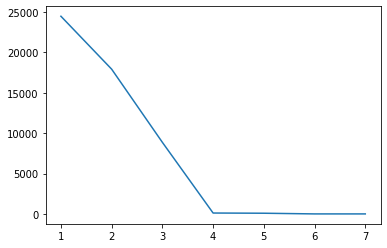

In [52]:
plt.plot(trial,s)

In [ ]:
np.mean(nw.Wout[nw.Wout<0])

In [ ]:
np.mean(nw.Wout[nw.Wout>0])

In [ ]:
np.array(range(2,8))

In [ ]:
for i in range(2,8):
    nw.Wout = np.dot(u[:,:i],np.dot(np.diag(s[:i]),vh[:i,:]))
    test(nw)
    print(top_2_accuracy(y_test,nw.Y))
#x = np.arange(1,7)
#plt.plot(x,error)

In [ ]:
np.linalg.matrix_rank(nw.Wout)

In [ ]:
np.round(u[:,:6]*1000)

In [ ]:
nw.Wout = np.dot(u[:,:6],np.dot(np.diag(s[:6]),vh[:6,:]))
test(nw)
top_2_accuracy(y_test,nw.Y)

In [ ]:
class ReberGrammarLexicon2(object):

    lexicon = set() #contain Reber words
    graph = [ [(1,'T'), (2,'P')], \
              [(1,'S'), (1,'X'), (2,'X'), (4,'S')], \
              [(2,'T') ,(3, 'V')],  \
              [(1, 'P'),(4, 'V')],  \
              [(5,'E')] ]  #store the graph

    def __init__(self, num, maxSize = 1000): #fill Lexicon with num words

        self.maxSize = maxSize

        if maxSize < 5:
            raise NameError('maxSize too small, require maxSize > 4') 

        while len(self.lexicon) < num:

            word = self.generateWord()
            if word != None:
                self.lexicon.add(word)

    def generateWord(self): #generate one word

    #    c = 2
        currentEdge = 0
        word = 'B'

        while True:

            inc = rnd.randint(0,len(self.graph[currentEdge])-1)
            nextEdge = self.graph[currentEdge][inc][0]
            word += self.graph[currentEdge][inc][1]
            currentEdge = nextEdge
            if currentEdge == 5 :
                break
    #        c+=1

    #    if c > self.maxSize :
    #        return None

        return word
generator = ReberGrammarLexicon2(2000,maxSize=20)
generator.lexicon

In [ ]:
training_set = preprocessing(list(generator.lexicon)[:2000])
training_set.shape

In [ ]:
nw.trainLen = 300
nw.data = training_set
nw.x = np.zeros((nw.resSize,1))
nw = learning_phase(nw)
#nw.x_ini = nw.x
nw = test(nw)

In [ ]:
# Graph 1: Comparison between expected and estimated outputs

In [ ]:
var7 = FloatSlider(value=2000,min=10,max=10000,step=10,description='time steps')
valid = Button(description='Validate')
        
def trace_graph1(_) :
    clear_output()
    f=int(var7.value)
    plt.figure(1).clear()
    plt.figure(figsize=(12,7))
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+f+1], 'g' )
    plt.plot( nw.Y.T[0:f], 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph1)
    
display(var7)
display(valid)

In [ ]:
# Graph 2: Difference between expected and estimated outputs

In [ ]:
var8 = FloatSlider(value=2000,min=10,max=nw.testLen,step=10,description='time steps')
var9 = FloatSlider(value=0.2,min=0.001,max=10,step=0.001,description='amplitude')
valid = Button(description='Validate')
        
def trace_graph2(_) :
    clear_output()
    f=int(var8.value)
    amp=float(var9.value)
    plt.figure(2).clear()
    plt.figure(figsize=(12,7))
    plt.ylim([-amp,amp])
    plt.plot(nw.data[nw.trainLen+1:nw.trainLen+f+1]-nw.Y[0][0:f], 'g' )
    print(nw.Y[0].shape)
    plt.title('Target and predicted signal difference through time')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph2)
    
display(var8)
display(var9)
display(valid)

In [ ]:
# Graph 3: Plotting neurons activations (total)

In [ ]:
var10 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var11 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='number of neurons')
valid = Button(description='Validate')

def trace_graph3(_) :
    clear_output()
    f=int(var10.value)
    nb=int(var11.value)
    plt.figure(3).clear()
    plt.figure(figsize=(10,7))
    plt.plot( nw.X[2:2+nb,0:f].T )
    print(nw.X.shape)
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for '+str(f)+' time steps')
    
valid.on_click(trace_graph3)
    
display(var10)
display(var11)
display(valid)

In [ ]:
nw.X.shape

In [ ]:
# Graph 4: Plotting single neuron activation

In [ ]:
var12 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var13 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='neuron ID')
valid = Button(description='Validate')

def trace_graph4(_) :
    clear_output()
    f=int(var12.value)
    num=int(var13.value)
    plt.figure(4).clear()
    plt.figure(figsize=(10,5))
    plt.plot( nw.X[2+num,:f].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for '+str(f)+' time steps')

valid.on_click(trace_graph4)

display(var12)
display(var13)
display(valid)

In [ ]:
# Graph 5: Output weights at the end of the simulation

In [ ]:
valid = Button(description='Show')

def trace_graph5(_) :
    clear_output()
    plt.figure(5).clear()
    plt.figure(figsize=(12,7))
    plt.bar(range(1+nw.inSize+nw.resSize), np.squeeze(nw.Wout.T) )
    plt.title('Output weights $\mathbf{W}^{out}$')

valid.on_click(trace_graph5)

display(valid)


In [ ]:
mat = [[1,0,0,0,0,0,0], [0,0,1,0,1,0,0], [0,0,0,1,0,0,1], [0,0,0,0,1,1,0], [0,0,1,0,0,1,0], [0,1,0,0,0,0,0]]

In [ ]:
mat[1:5]

In [ ]:
np.linalg.matrix_rank(mat[1:5])